# **Netflix Capstone Project: Movie Recommendation System**
____

### **Project Objective:**
**The primary objective of this project is to develop an efficient and accurate movie recommendation system (a collaborative filtering Machine Learning model) using SVD. The system aims to predict movie ratings for users and generate a list of top movie recommendations for each user.**
___

In [1]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

In [ ]:
# Reding the data
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/netflix_dataset.zip')
df.head(10)

,,1:
1488844,3.0,2005-09-06
822109,5.0,2005-05-13
885013,4.0,2005-10-19
30878,4.0,2005-12-26
823519,3.0,2004-05-03
893988,3.0,2005-11-17
124105,4.0,2004-08-05
1248029,3.0,2004-04-22
1842128,4.0,2004-05-09
2238063,3.0,2005-05-11


It seems that there are no headers present in the data. So the dataframe is not named accurately.

Since we know that the first column contains the ID's and the others columns are Movie ratings and Date columns respectively, lets import the file into the dataframe again, but this time with accurate namings. Also we will exclude the date column as it is not needed in our operation.

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/netflix_dataset.zip',header=None,usecols=[0,1],names=['UserID','Rating'])
df.head(10)

,UserID,Rating
0,1:,NaN
1,1488844,3.0
2,822109,5.0
3,885013,4.0
4,30878,4.0
5,823519,3.0
6,893988,3.0
7,124105,4.0
8,1248029,3.0
9,1842128,4.0


In [3]:
df.tail(10)

,UserID,Rating
24058253,272857,4.0
24058254,185372,1.0
24058255,2219917,3.0
24058256,1796454,1.0
24058257,2562830,4.0
24058258,2591364,2.0
24058259,1791000,2.0
24058260,512536,5.0
24058261,988963,3.0
24058262,1704416,3.0


## Exploratory Data Analysis

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24058263 entries, 0 to 24058262
Data columns (total 2 columns):
 #   Column  Dtype  
---  ------  -----  
 0   UserID  object 
 1   Rating  float64
dtypes: float64(1), object(1)
memory usage: 367.1+ MB


In [5]:
df.isnull().sum()

UserID       0
Rating    4499
dtype: int64

It seems there are 4499 NaN values from our observations

In [6]:
df[df.isnull().any(axis=1)]

,UserID,Rating
0,1:,NaN
548,2:,NaN
694,3:,NaN
2707,4:,NaN
2850,5:,NaN
...,...,...
24046714,4495:,NaN
24047329,4496:,NaN
24056849,4497:,NaN
24057564,4498:,NaN


Now these rows cotaining null values in ratings and values from 1 to 4499 in order inside UserID's are acutually our movie ID's.

In [7]:
# Checking the total count of all the ratings
df.groupby('Rating')['Rating'].agg(['count'])

,count
Rating,
1.0,1118186
2.0,2439073
3.0,6904181
4.0,8085741
5.0,5506583


**Visualizing the data**

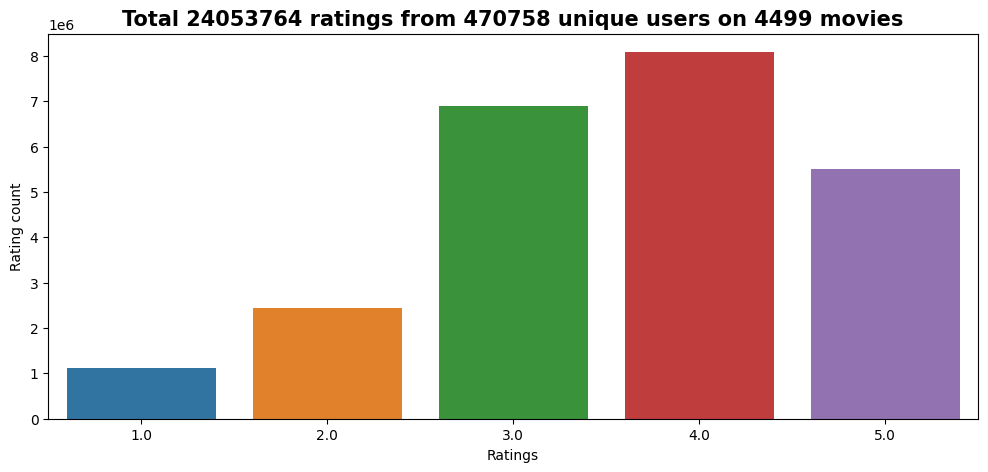

In [8]:
plt.figure(figsize=(12,5))
sb.countplot(df,x='Rating')
plt.title(f'Total {len(df.dropna())} ratings from {df.dropna()["UserID"].nunique()} unique users on '
          f'{len(df[df.isna().any(axis=1)])} movies',fontsize=15,fontweight='bold')
plt.xlabel('Ratings')
plt.ylabel('Rating count')
plt.show()

The most number of votes are on 4 stars

## Data Cleaning

In [9]:
df['MovieID'] = df.apply(lambda x: x['UserID'].split(':')[0] if pd.isnull(x['Rating']) else np.nan, axis=1)
df[df.Rating.isnull()]

,UserID,Rating,MovieID
0,1:,NaN,1
548,2:,NaN,2
694,3:,NaN,3
2707,4:,NaN,4
2850,5:,NaN,5
...,...,...,...
24046714,4495:,NaN,4495
24047329,4496:,NaN,4496
24056849,4497:,NaN,4497
24057564,4498:,NaN,4498


In the previous operation we created a new feature called MovieID and fill it with the value in UserID wherever Ratings feature value was NaN(also we use a string operation to fill it with only the number value) and the rest of the rows was made into Null values.

Now we will use fillna() with forward fill method to fill all the NaN with respective values which preceeds the NaN

In [10]:
df['MovieID'].fillna(method='ffill',inplace=True)


In [11]:
df

,UserID,Rating,MovieID
0,1:,NaN,1
1,1488844,3.0,1
2,822109,5.0,1
3,885013,4.0,1
4,30878,4.0,1
...,...,...,...
24058258,2591364,2.0,4499
24058259,1791000,2.0,4499
24058260,512536,5.0,4499
24058261,988963,3.0,4499


Now we will just drop all the rows containing null values to get the data in the cleaned format

In [12]:
df.dropna(inplace=True)
df

,UserID,Rating,MovieID
1,1488844,3.0,1
2,822109,5.0,1
3,885013,4.0,1
4,30878,4.0,1
5,823519,3.0,1
...,...,...,...
24058258,2591364,2.0,4499
24058259,1791000,2.0,4499
24058260,512536,5.0,4499
24058261,988963,3.0,4499


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24053764 entries, 1 to 24058262
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   UserID   object 
 1   Rating   float64
 2   MovieID  object 
dtypes: float64(1), object(2)
memory usage: 734.1+ MB


Since our ID columns are whole numbers lets convert it into int datatype

In [14]:
df[['UserID','MovieID']] = df[['UserID','MovieID']].astype(int)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24053764 entries, 1 to 24058262
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   UserID   int64  
 1   Rating   float64
 2   MovieID  int64  
dtypes: float64(1), int64(2)
memory usage: 734.1 MB


In [16]:
# Checking the number of unique users
df['UserID'].nunique()

470758

In [17]:
# Checking for any duplictae rows in the dataframe
df.duplicated().sum()

0

In [18]:
df

,UserID,Rating,MovieID
1,1488844,3.0,1
2,822109,5.0,1
3,885013,4.0,1
4,30878,4.0,1
5,823519,3.0,1
...,...,...,...
24058258,2591364,2.0,4499
24058259,1791000,2.0,4499
24058260,512536,5.0,4499
24058261,988963,3.0,4499


## Preparing The Training Data

**Lets get the rating count of each user**

In [19]:
user_rating_count = df.groupby('UserID')['Rating'].agg(['count'])
user_rating_count

,count
UserID,
6,153
7,195
8,21
10,49
25,4
...,...
2649404,12
2649409,10
2649421,3


**Lets get the rating counts for each movie**

In [20]:
movie_rating_count = df.groupby('MovieID')['Rating'].agg(['count'])
movie_rating_count

,count
MovieID,
1,547
2,145
3,2012
4,142
5,1140
...,...
4495,614
4496,9519
4497,714


One important thing we have to consider is that we dont want to train the recommendation model on movies that doesnt have much number of ratings and also on users that have given low number of ratings. items with very few ratings count may not provide sufficient information for the model to learn meaningful patterns or preferences. Removing these instances can greatly improve the quality of the training data.

Lets us set the benchmark at 70% for both movie ratings count and user ratings count, where only 70% or above of the total count of ratings for both movies and user ratings count will be considered in our dataset that will be used for training the recommendation model.

In [21]:
movie_rating_count_benchmark = movie_rating_count.quantile(0.70).round(0)[0]
user_rating_count_benchmark = user_rating_count.quantile(0.70).round(0)[0]

In [22]:
print(f'Taking 70% as the cutoff benchmark, the minimum movie ratings count should be {movie_rating_count_benchmark} and minmum user ratings'
      f'\ncount should be {user_rating_count_benchmark} for it to be considered for training')

Taking 70% as the cutoff benchmark, the minimum movie ratings count should be 1799.0 and minmum user ratings
count should be 52.0 for it to be considered for training


Filtering the Dataset

In [23]:
# Here we are filtering and acquiring the index of only those that satisfy our benchmark criteria
user_rating_id_filter = user_rating_count[user_rating_count['count'] >= user_rating_count_benchmark].index
movie_rating_id_filter = movie_rating_count[movie_rating_count['count'] >= movie_rating_count_benchmark].index

In [24]:
df = df[df['UserID'].isin(user_rating_id_filter)]
df = df[df['MovieID'].isin(movie_rating_id_filter)]
df.shape

(17337458, 3)

In [25]:
# This is the final fully cleaned dataset which can now be fed into our SVD model for training
df = df[['UserID','MovieID','Rating']]
df

,UserID,MovieID,Rating
696,712664,3,5.0
697,1331154,3,4.0
698,2632461,3,3.0
699,44937,3,5.0
700,656399,3,4.0
...,...,...,...
24056841,520675,4496,3.0
24056842,1055714,4496,5.0
24056843,2643029,4496,4.0
24056845,1559566,4496,3.0


Here i changed the order of the columns as this is the default order expected by the SVD model for these features

**Lets check the count of ratings now that our data is cleaned**

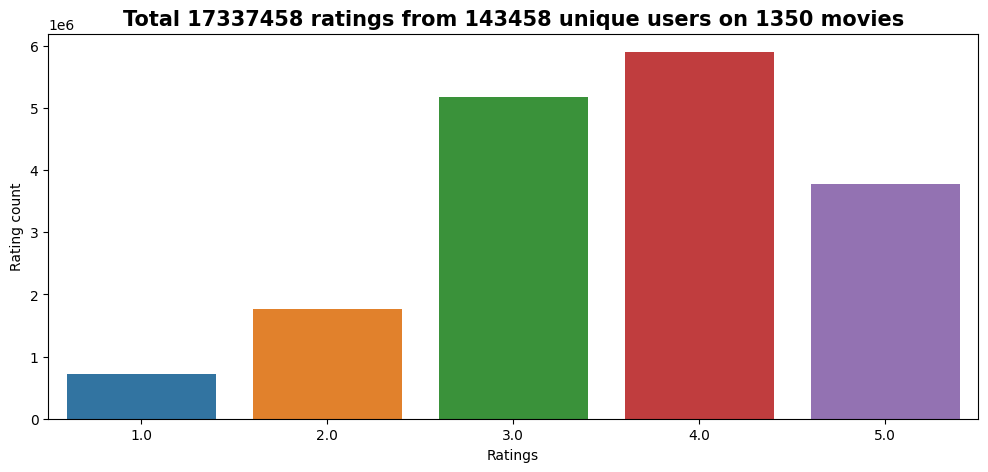

In [26]:
plt.figure(figsize=(12,5))
sb.countplot(df,x='Rating')
plt.title(f'Total {len(df)} ratings from {df["UserID"].nunique()} unique users on '
          f'{df["MovieID"].nunique()} movies',fontsize=15,fontweight='bold')
plt.xlabel('Ratings')
plt.ylabel('Rating count')
plt.show()

**Therefore after filtering based on the benchmark, we have 17337458 records rather than the initial 24053764 records, 143458 unique users and 1350 unique movies**

Now importing the movie titles table infto a dataframe

In [27]:
movie_titles = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/movie_titles.csv',\
                           encoding='unicode_escape',usecols=[0,1,2],names=['Movie_Id','Year','Name']).set_index('Movie_Id')
movie_titles
# We need this dataset to obtain the name of the movie related to the index

,Year,Name
Movie_Id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW
...,...,...
17766,2002.0,Where the Wild Things Are and Other Maurice Se...
17767,2004.0,Fidel Castro: American Experience
17768,2000.0,Epoch


In [28]:
movie_titles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17770 entries, 1 to 17770
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Year    17763 non-null  float64
 1   Name    17770 non-null  object 
dtypes: float64(1), object(1)
memory usage: 416.5+ KB


In [29]:
movie_titles[movie_titles.isna().any(axis=1)]

,Year,Name
Movie_Id,,
4388,NaN,Ancient Civilizations: Rome and Pompeii
4794,NaN,Ancient Civilizations: Land of the Pharaohs
7241,NaN,Ancient Civilizations: Athens and Greece
10782,NaN,Roti Kapada Aur Makaan
15918,NaN,Hote Hote Pyaar Ho Gaya
16678,NaN,Jimmy Hollywood
17667,NaN,Eros Dance Dhamaka


In [30]:
movie_titles.index.nunique()

17770

## Model Building

In [31]:
# Installing the scikit-surprise which is a library that contains the SVD model which we need
! pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 10.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163749 sha256=8275d6ee40f3c9b49e0049f7f538ccf707ff1bb60216edb5217c64b237123159
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [32]:
# Importing the necessary libraries
from surprise import accuracy
from surprise import Reader, Dataset, SVD, SVDpp
from surprise.model_selection import train_test_split, cross_validate, KFold

In [33]:
reader = Reader()
data = Dataset.load_from_df(df,reader)
data

**The Dataset class have methods which help us in loading and processing the data, preparing it in a format suitable for training models like SVD.**

**The Reader class defines how to read and interpret the dataset, ensuring compatibility with the SVD model.**

In [34]:
svd = SVD(random_state=7)

## Checking Model Performance

In [35]:
# KFold in this case helps you to set a random state for your cross validation so that your results can be reproduced
kfold = KFold(n_splits=5,shuffle=True,random_state=7)
performance = cross_validate(svd, data, measures=['rmse','mae'], cv=kfold, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8482  0.8482  0.8482  0.8479  0.8484  0.8482  0.0002  
MAE (testset)     0.6583  0.6585  0.6586  0.6585  0.6589  0.6586  0.0002  
Fit time          300.29  318.80  314.16  316.24  316.63  313.23  6.63    
Test time         74.85   67.99   67.71   76.03   67.91   70.90   3.73    


**As we can see from the results above both RMSE and MAE are close to 0. So this model has very good performance and can give reliable results**

## Getting The Movie Recommendations

In [37]:
# Checking the count of ratings by each unique user
user_rating_count = df.groupby('UserID')['Rating'].agg(['count']).sort_values(by='count',ascending=False)

In [38]:
user_rating_count.shape

(143458, 1)

In [39]:
user_rating_count.iloc[100:120,:]

,count
UserID,
74441,679
789969,677
1139570,677
1370564,674
1301819,674
1935793,671
1806515,671
2541385,671
2061495,668


### Now that the model is trained lets see how SVD helps in recommending movies that are not yet rated by the user

**Let us predict for userid 1792741 who has rated 761 movies so far out of 1350 unique movies inside our model**

In [40]:
# To filter out all the movies seen by tis user
user_1792741 = df[(df['UserID'] == 1792741)]
user_1792741

,UserID,MovieID,Rating
33127,1792741,18,2.0
47290,1792741,26,3.0
58805,1792741,28,3.0
226113,1792741,44,5.0
236944,1792741,46,5.0
...,...,...,...
23957467,1792741,4479,1.0
23982544,1792741,4485,3.0
23990744,1792741,4488,2.0
24021705,1792741,4490,5.0


### **We want to filter out all the movies already seen by this user because, we want our model to give predictions on movies that are in the training model but, that which are not yet rated by the user in question.**
---
This is done because **SVD is a collaborative filtering model** and it can make predictions for users and movies that were part of the training dataset. The model has learned latent patterns betwen these users and movies during the training process.

But making predictions for entirely new users or movies that were not present in the training set can be difficult for the model. This is due to the lack of historical interactions for these new movies and users with the existing training set. This is also known as the "cold start" problem, and collaborative filtering models like **SVD, may struggle to provide accurate predictions in such cases.**

---

### **For a given user, the model identifies other users who are similar to them based on their historical interactions with the movies. The model then predicts the rating that the current user might give to an unrated item by considering the ratings given by similar users to that item.**

In [41]:
# Here we filter out all the movies that are seen by the user already
movies_to_predict = list(set(df['MovieID']) - set(user_1792741['MovieID']))
print(movies_to_predict)

[3, 4100, 8, 4106, 4109, 16, 17, 2077, 30, 2078, 32, 33, 2080, 4131, 45, 48, 4144, 52, 4149, 55, 56, 2103, 4155, 2112, 2113, 4161, 68, 4168, 4173, 78, 79, 2129, 4177, 84, 2136, 4185, 2144, 97, 2149, 2152, 4201, 111, 4210, 2164, 2171, 2173, 2176, 4225, 133, 4237, 4238, 2192, 148, 4247, 156, 4253, 4255, 4260, 165, 4262, 2216, 2218, 4266, 4267, 4269, 175, 4271, 178, 180, 181, 2228, 4282, 187, 188, 2235, 191, 197, 199, 201, 2254, 213, 2262, 4310, 216, 2269, 223, 225, 2276, 2284, 238, 239, 242, 248, 4345, 252, 255, 256, 257, 4353, 4354, 4355, 4360, 269, 270, 4366, 275, 2326, 4374, 2329, 4377, 283, 4380, 2335, 4384, 289, 290, 2339, 4387, 4389, 2342, 295, 4390, 297, 299, 2350, 4407, 313, 2362, 4411, 2366, 2370, 4420, 329, 4429, 334, 2383, 4432, 2385, 2386, 2388, 2391, 4441, 348, 2400, 353, 4450, 356, 357, 2405, 360, 361, 362, 4460, 367, 4463, 4465, 2422, 4472, 378, 4478, 2443, 4493, 4496, 401, 405, 406, 408, 2457, 413, 416, 2465, 418, 2467, 424, 425, 2475, 431, 432, 433, 2482, 436, 438, 442, 

In [42]:
len(movies_to_predict)

589

**Now we use svd.predict, to predict an estimate rating, that the user might give for each movie, that the user have not seen.**

In [43]:
user_1792741_predictions = [svd.predict(1792741, movies) for movies in movies_to_predict]
user_1792741_predictions[:15]
# Our output is in this object format. Lets make it more readable

[Prediction(uid=1792741, iid=3, r_ui=None, est=2.6844356588257665, details={'was_impossible': False}),
 Prediction(uid=1792741, iid=4100, r_ui=None, est=2.9603060431830346, details={'was_impossible': False}),
 Prediction(uid=1792741, iid=8, r_ui=None, est=3.157456196851271, details={'was_impossible': False}),
 Prediction(uid=1792741, iid=4106, r_ui=None, est=1.6603518086788536, details={'was_impossible': False}),
 Prediction(uid=1792741, iid=4109, r_ui=None, est=1.4913709071919732, details={'was_impossible': False}),
 Prediction(uid=1792741, iid=16, r_ui=None, est=2.3273523453125824, details={'was_impossible': False}),
 Prediction(uid=1792741, iid=17, r_ui=None, est=2.2433406182664477, details={'was_impossible': False}),
 Prediction(uid=1792741, iid=2077, r_ui=None, est=2.5602818328025507, details={'was_impossible': False}),
 Prediction(uid=1792741, iid=30, r_ui=None, est=3.1684728900760355, details={'was_impossible': False}),
 Prediction(uid=1792741, iid=2078, r_ui=None, est=1.5427143

In [44]:
# Here we are making prediction for our user into an easily readable format
user_1792741_predictions_df = pd.DataFrame(user_1792741_predictions,columns=['UserID','MovieID','Rating','Rating_Estimate','temp'])
# Sorting values based on the estimate rating to see the ones with the highest ratings
user_1792741_predictions_df = user_1792741_predictions_df.iloc[:,:4].sort_values('Rating_Estimate',ascending=False)
user_1792741_predictions_df

,UserID,MovieID,Rating,Rating_Estimate
62,1792741,4266,None,4.642003
10,1792741,32,None,4.512658
434,1792741,3456,None,4.201155
463,1792741,1513,None,4.165217
31,1792741,2129,None,4.129873
...,...,...,...,...
332,1792741,3085,None,1.000000
271,1792741,761,None,1.000000
277,1792741,808,None,1.000000
318,1792741,977,None,1.000000


**Now we will merge the resultant dataframe with the movies table to get the names of the movies based on the movie id's**

In [45]:
user_1792741_predictions_df = user_1792741_predictions_df.merge(movie_titles[['Name','Year']],left_on='MovieID',right_index=True,how='left')
user_1792741_predictions_df

,UserID,MovieID,Rating,Rating_Estimate,Name,Year
62,1792741,4266,None,4.642003,The Passion of the Christ,2004.0
10,1792741,32,None,4.512658,ABC Primetime: Mel Gibson's The Passion of the...,2004.0
434,1792741,3456,None,4.201155,Lost: Season 1,2004.0
463,1792741,1513,None,4.165217,The Twilight Zone: Vol. 42,1962.0
31,1792741,2129,None,4.129873,The Twilight Zone: Vol. 41,1960.0
...,...,...,...,...,...,...
332,1792741,3085,None,1.000000,Little Nicky,2000.0
271,1792741,761,None,1.000000,O Fantasma,2000.0
277,1792741,808,None,1.000000,Dead Man on Campus,1998.0
318,1792741,977,None,1.000000,Our Lady of the Assassins,2000.0


**The Top 10 recommendations for UserID 1792741 based our SVD recommendation model:**

In [46]:
user_1792741_predictions_df.head(10)

,UserID,MovieID,Rating,Rating_Estimate,Name,Year
62,1792741,4266,None,4.642003,The Passion of the Christ,2004.0
10,1792741,32,None,4.512658,ABC Primetime: Mel Gibson's The Passion of the...,2004.0
434,1792741,3456,None,4.201155,Lost: Season 1,2004.0
463,1792741,1513,None,4.165217,The Twilight Zone: Vol. 42,1962.0
31,1792741,2129,None,4.129873,The Twilight Zone: Vol. 41,1960.0
546,1792741,1856,None,4.084050,The Twilight Zone: Vol. 39,1960.0
515,1792741,3798,None,4.003209,The Sting,1973.0
148,1792741,2405,None,3.863623,MI-5: Vol. 2,2003.0
283,1792741,825,None,3.841054,Bill Cosby: Himself,1983.0
476,1792741,3624,None,3.839562,The Last Samurai,2003.0


_________

## **Streamlining The Prediction Process**



#### **Let's streamline the process of discovering optimal movie recommendations for a user by encapsulating it within a single function, making the entire operation more efficient and less cumbersome.**

In [47]:
# This function will take in the UserID and returns the top 10 movie recommendations for that user
def get_recommendation(userid, model=svd, dataset=df, movie_names_df=movie_titles):

    # Getting list of movies the user haven't rated/watched
    predict_for = list(set(dataset['MovieID']) - set(dataset[dataset['UserID'] == userid]['MovieID']))
    # Finding the estimated rating for these movies using SVD
    predictions = [model.predict(userid,movieid) for movieid in predict_for]
    # Creating a DataFrame for the predictions
    predictions_df = pd.DataFrame(predictions,columns=['UserID','MovieID','Rating','Rating_Estimate','temp'])
    # Dropping unwanted column and sorting the DataFrame based on predicted rating in descending order
    predictions_df = predictions_df.iloc[:,:4].sort_values('Rating_Estimate',ascending=False)
    # Merging the predictions, the movie names and the year of release based on MovieID
    predictions_with_titles_df = predictions_df.merge(movie_names_df[['Name','Year']],left_on='MovieID',right_index=True,how='left')
    # Declaring global variable called recommendation, which can be called outside this function also
    global recommendation
    # Assigning the predictions to recommendation
    recommendation = predictions_with_titles_df
    print(f'The Top 10 recommendations for User {userid} are:\n')
    # The function returns the top 10 recommendations.
    # The whole prediction DataFrame can also be viewed outside this function by calling recommendation
    return recommendation.head(10)


**Recommendations for user 2157060**

In [48]:
get_recommendation(2157060)

The Top 10 recommendations for User 2157060 are:



,UserID,MovieID,Rating,Rating_Estimate,Name,Year
135,2157060,4386,None,4.129636,The Return of the Living Dead,1985.0
381,2157060,1032,None,4.111412,Hard Boiled,1992.0
596,2157060,1770,None,4.108964,Trainspotting,1995.0
671,2157060,4054,None,4.079888,House of Cards Trilogy I: House of Cards,1990.0
266,2157060,677,None,3.992938,In the Mood for Love,2001.0
26,2157060,2102,None,3.981971,The Simpsons: Season 6,1994.0
337,2157060,889,None,3.953479,Reno 911: Season 2,2004.0
288,2157060,733,None,3.889636,Dead Ringers,1988.0
349,2157060,2965,None,3.875628,The Seventh Seal,1957.0
285,2157060,2778,None,3.873328,Pink Floyd: Live at Pompeii: Director's Cut,1974.0


**Recommendations for User 1806515**

In [59]:
get_recommendation(1806515)

The Top 10 recommendations for User 1806515 are:



,UserID,MovieID,Rating,Rating_Estimate,Name,Year
505,1806515,3456,None,4.555412,Lost: Season 1,2004.0
318,1806515,825,None,4.164141,Bill Cosby: Himself,1983.0
461,1806515,1256,None,4.116051,The Best of Friends: Vol. 4,1994.0
665,1806515,4033,None,4.066387,Alias: Season 4,2005.0
296,1806515,2803,None,4.042151,Pride and Prejudice,1995.0
501,1806515,3446,None,4.031224,Spirited Away,2002.0
247,1806515,2651,None,4.025045,Dragon Ball Z: Super Android 13,1992.0
504,1806515,1409,None,4.023350,The O.C.: Season 1,2003.0
641,1806515,3928,None,4.003150,Nip/Tuck: Season 2,2004.0
580,1806515,1703,None,3.975640,Ever After: A Cinderella Story,1998.0


____